In [1]:
import json
from tqdm.notebook import tqdm
from vespa.deployment import VespaDocker
from vespa.io import VespaResponse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [2]:
docs_json_path = 'data/istella/cleaned_documents_with_embeddings.jsonl'

istella_docs = []
with open(docs_json_path, 'r', encoding='utf-8') as f:
    total_lines = sum(1 for _ in f)
    f.seek(0) 
    
    for line in tqdm(f, total=total_lines, desc="Loading documents"):
        doc = json.loads(line)
        istella_docs.append(doc)  

print(f"Total documents loaded: {len(istella_docs)}")
print("Sample document:", istella_docs[0])

embedding_dimension = 384  # 384 for SBERT
#embedding_dimension = 768 # 768 for multilang

Loading documents:   0%|          | 0/262842 [00:00<?, ?it/s]

Total documents loaded: 262842
Sample document: {'doc_id': '1990010000000162', 'title': 'Skitourenkurs, Skireisen, Freeride - Mountain Elements', 'url': 'http://www.mountain-elements.com/', 'text': "Alpinklettern – Hochtouren – Klettersteige – Kletterreisen – Skitouren – Freeride – Eisklettern – Skireisen Wir versuchen immer im Schlechtwetterfall, die besten Alternativen zur vorhandenen Situation zu finden. Natürlich ist man da bei mehrtägigen Touren flexibler, denn dann lohnen auch etwas weitere Ortswechsel. Nachdem Mountain Elements in den gesamten Alpen zu Hause ist, sind wir da sehr kreativ! “War in Grönland (2014). Super Reise und absolut professionell durch Benno geführt. Kann ich wirklich jedem empfehlen. Weiter so Mountain Elements :)!” Das Team von Mountain Elements Mountain Elements info@mountain-elements.com +49 (0)8061 3498042 Mountain Elements GmbH Lindenstr. 5 D-83043 Bad Aibling Mountain Elements GmbH Lindenstr. 5 D-83043 Bad Aibling Freeride Wir sind Bergführer aus Leid

In [3]:
# This code defines a Vespa application package named "istvespa".
# It specifies a schema, also named "istvespa", which outlines the structure of documents, mainly how they are indexed, and how they are ranked in search results.
# The application supports both traditional keyword search (using BM25) and semantic search (using embeddings) and lastly a hybrid approach that combines both.
# In hybrid approach we use BM25 to rank documents based on keyword matches and embeddings to rank documents based on semantic similarity. 
# We use Reciprocal Rank Fusion to combine the two ranking signals.


from vespa.package import (
    ApplicationPackage,
    Field,
    Schema,
    Document,
    HNSW,
    RankProfile,
    Component,
    Parameter,
    FieldSet,
    GlobalPhaseRanking,
    Function,
)

package = ApplicationPackage(
    name="istvespa",
    schema=[
        Schema(
            name="istvespa",
            document=Document(
                fields=[
                    Field(name="doc_id", type="string", indexing=["summary"]),
                    Field(
                        name="title",
                        type="string",
                        indexing=["index", "summary"],
                        index="enable-bm25",
                    ),
                    Field(
                        name="text",
                        type="string",
                        indexing=["index", "summary"],
                        index="enable-bm25",
                        bolding=True,
                    ),
                    Field(
                        name="embedding",
                        type=f"tensor<float>(x[{embedding_dimension}])",
                        indexing=["index", "attribute"],
                        ann=HNSW(distance_metric="angular"),
                        #is_document_field=False,
                    ),
                ]
            ),
            fieldsets=[FieldSet(name="default", fields=["title", "text"])],
            rank_profiles=[
                RankProfile(
                    name="bm25",
                    inputs=[("query(q)", f"tensor<float>(x[{embedding_dimension}])")],
                    functions=[
                        Function(name="bm25sum", expression="bm25(title) + bm25(text)")
                    ],
                    first_phase="bm25sum",
                ),
                RankProfile(
                    name="semantic",
                    inputs=[("query(q)", f"tensor<float>(x[{embedding_dimension}])")],
                    first_phase="closeness(field, embedding)",
                ),
                RankProfile(
                    name="fusion",
                    inherits="bm25",
                    inputs=[("query(q)", f"tensor<float>(x[{embedding_dimension}])")],
                    first_phase="closeness(field, embedding)",
                    global_phase=GlobalPhaseRanking(
                        expression="reciprocal_rank_fusion(bm25sum, closeness(field, embedding))",
                        rerank_count=1000,
                    ),
                ),
            ],
        )
    ]
)

In [4]:
# from vespa.package import ApplicationPackage
# app_package = ApplicationPackage(name="istvespa")

In [5]:
# from vespa.package import Document, Field, HNSW
# products_document = Document(
#     fields=[
#         Field(name = "doc_id",    type = "string", indexing = ["attribute", "summary"]),
#         Field(name = "title",    type = "string", indexing = ["index", "summary"], index = "enable-bm25"),
#         Field(name = "text", type = "string", indexing = ["index", "summary"], index = "enable-bm25"),
#         Field(name = "extra_text", type = "string", indexing = ["index", "summary"], index = "enable-bm25"),
#         Field(name="embedding", type=f"tensor<float>(x[{embedding_dimension}])", indexing=["attribute", "index"],
#             ann=HNSW(
#                 distance_metric="angular",
#                 max_links_per_node=16,
#                 neighbors_to_explore_at_insert=500),
#         )
#     ]
# )

In [6]:
# from vespa.package import Schema, FieldSet, RankProfile

# products_schema = Schema(
#     name="istvespa",
#     document=products_document,
#     fieldsets=[FieldSet(name="default", fields=["title", "text"])],
#     rank_profiles=[
#         RankProfile(name="bm25", inherits="default", first_phase="bm25(title) + bm25(text)"),
#         RankProfile(name="nativeRank", inherits="default", first_phase="nativeRank(title,text)"),
#         RankProfile(name="embedding_similarity", inherits="default", first_phase="closeness(embedding)"),
#         RankProfile(name="bm25_embedding_similarity", inherits="default", first_phase="bm25(title) + bm25(text)  + closeness(embedding)")
#     ]
# )

In [7]:
# from vespa.package import ApplicationPackage, QueryProfile, QueryProfileType, QueryTypeField

# app_package = ApplicationPackage(
#     name="myapp",
#     schema=[products_schema], 
#     query_profile=QueryProfile(),
#     query_profile_type=QueryProfileType(
#         fields=[
#                 QueryTypeField(
#                 name="ranking.features.query(embedding_text)",
#                 type=f"tensor<float>(x[{embedding_dimension}])",
#             )
#         ]
#     )
# )

In [8]:
print(package.get_schema('istvespa').schema_to_text)

schema istvespa {
    document istvespa {
        field doc_id type string {
            indexing: summary
        }
        field title type string {
            indexing: index | summary
            index: enable-bm25
        }
        field text type string {
            indexing: index | summary
            index: enable-bm25
            bolding: on
        }
        field embedding type tensor<float>(x[384]) {
            indexing: index | attribute
            attribute {
                distance-metric: angular
            }
            index {
                hnsw {
                    max-links-per-node: 16
                    neighbors-to-explore-at-insert: 200
                }
            }
        }
    }
    fieldset default {
        fields: title, text
    }
    rank-profile bm25 {
        inputs {
            query(q) tensor<float>(x[384])             
        
        }
        function bm25sum() {
            expression {
                bm25(title) + bm25(text)
    

In [9]:
vespa_docker = VespaDocker(container_memory="22G")
app = vespa_docker.deploy(application_package=package)

print("Vespa deployed successfully.")

Waiting for configuration server, 0/60 seconds...
Waiting for configuration server, 5/60 seconds...
Waiting for application to come up, 0/300 seconds.
Waiting for application to come up, 5/300 seconds.
Waiting for application to come up, 10/300 seconds.
Waiting for application to come up, 15/300 seconds.
Waiting for application to come up, 20/300 seconds.
Application is up!
Finished deployment.
Vespa deployed successfully.


In [10]:
batch_feed = []
for doc in istella_docs:
    vespa_doc = {
        "doc_id": doc['doc_id'],
        "title": doc['title'],  
        "text": doc['text'],
        #"extra_text": doc['extra_text'],   
        "embedding": {
            "values": doc['embedding']
        }
    }
    batch_feed.append({
        "fields": vespa_doc,
        "id": doc['doc_id']
    })
    
print(f"Total documents to feed: {len(batch_feed)}")


Total documents to feed: 262842


In [11]:
istella_docs_len = len(istella_docs)
istella_docs.clear()  #Clear the memory

In [12]:
success_count = 0
pbar = tqdm(total=istella_docs_len, desc="Feeding Docs", unit="doc")

def callback(response: VespaResponse, id: str):
    global success_count
    pbar.update(1)
    if response.is_successful():
        success_count += 1
    else:
        print(f"Failed doc {id}, status={response.status_code}: {response.get_json()}")

app.feed_iterable(batch_feed, schema="istvespa", callback=callback)

pbar.close()
print(f"[feed_docs] Feed complete. {success_count}/{istella_docs_len} successes.")

Feeding Docs:   0%|          | 0/262842 [00:00<?, ?doc/s]

Failed doc 1990010002626972, status=599: {'Exception': "In document 'id:istvespa:istvespa::1990010002626972': Could not parse field 'text' of type string: The string field value contains illegal code point 0xFFFF", 'id': '1990010002626972', 'message': 'Exception during feed_data_point'}
Failed doc 1990011101458792, status=599: {'Exception': "In document 'id:istvespa:istvespa::1990011101458792': Could not parse field 'text' of type string: The string field value contains illegal code point 0xFFFF", 'id': '1990011101458792', 'message': 'Exception during feed_data_point'}
Failed doc 1990011402535873, status=599: {'Exception': "In document 'id:istvespa:istvespa::1990011402535873': Could not parse field 'text' of type string: The string field value contains illegal code point 0xFFFF", 'id': '1990011402535873', 'message': 'Exception during feed_data_point'}
[feed_docs] Feed complete. 262839/262842 successes.


In [13]:
query = {
    'yql': 'select * from sources istvespa where userQuery();',
    'query': 'la tv del giorno dopo',
    'ranking': 'bm25',
    'type': 'any',
    'hits': 5
}

In [14]:
results = app.query(body=query)

print('Number of documents retrieved: '+ str(results.number_documents_retrieved))
print('Number of documents returned: '+ str(len(results.hits)))
print('Relevance of first document: '+ str(results.hits[0]['relevance']))
print('Document ID of first document: '+ str(results.hits[0]['id']))
print('Document ID of second document: '+ str(results.hits[1]['id']))
print('Document ID of third document: '+ str(results.hits[2]['id']))
print('Document ID of fourth document: '+ str(results.hits[3]['id']))
print('Document ID of fifth document: '+ str(results.hits[4]['id']))

Number of documents retrieved: 150705
Number of documents returned: 5
Relevance of first document: 29.887764868514545
Document ID of first document: id:istvespa:istvespa::1990012000639597
Document ID of second document: id:istvespa:istvespa::1990010401930977
Document ID of third document: id:istvespa:istvespa::1990011101114720
Document ID of fourth document: id:istvespa:istvespa::1990073802540319
Document ID of fifth document: id:istvespa:istvespa::1990012300458202


In [15]:
QUERIES_FILE = "data/istella/queries.test.jsonl"
QRELS_FILE = "data/istella/qrels.test"

def load_queries(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found.")
    queries_list = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            obj = json.loads(line)
            queries_list.append({
                "qid": obj["query_id"],
                "query": obj["text"]
            })
            print(obj["query_id"], obj["text"])
    return queries_list



def load_qrels(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"{path} not found.")
    qrels_dict = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            if (len(parts) != 4):
                print(f"Invalid line: {line}")
                continue
            qid, _, doc_id, relevance = parts[0], parts[1], parts[2], parts[3]
            relevance = int(relevance)

            if qid not in qrels_dict:
                qrels_dict[qid] = {}
            qrels_dict[qid][doc_id] = relevance
    return qrels_dict

queries = load_queries(QUERIES_FILE)
print(f"Total queries loaded: {len(queries)}")
qrels = load_qrels(QRELS_FILE)
print(f"Total qrels loaded: {len(qrels)}")

263 calcio mercato
326 cotto e mangiato
381 lavatrici ad ultrasuoni
480 giallo zafferano
515 stipendi pa
594 mediaset video
680 chat irc
788 gianna nannini
845 rosa rossa
1008 milano finanza
1069 lamberto sposini
1168 auto scout
1327 check language integrity
1421 comparativo francese
1498 chi sono petrarca e boccaccio
1586 previsioni del tempo
1652 traduttore inglese italiano
1832 posta certificata
1989 santa sede
2217 disney channel
2255 guarda film
2462 il terzo tempo
2490 estrazione del lotto
2519 oroscopo tiscali
2739 gioco digitale
2930 telecamere videosorveglianza
2969 comune di bonorva
3079 quote snai
3118 rai sport
3309 prefettura di cagliari
3569 mappa cagliari
3615 hit parade
3873 sinonimi e contrari
3906 distanze chilometriche
4168 cessione del quinto dipendenti
4175 la tv del giorno dopo
4228 juve forum
4296 quotazione oro usato roma
4450 michelin mappe
4468 corte dei conti
4637 albergo chianti
4797 apple store
4851 sclerosi multipla
4933 flexible shunts
4935 san raffaele
5

In [16]:
def preprocess_query(query_text):
    """Basic query preprocessing."""
    query = query_text.lower()
    query = query.replace('"', ' ')
    query = query.replace("'", ' ')
    return query

In [17]:
from vespa.io import VespaQueryResponse

def run_vespa_search(app, queries, top_k=30):
    trec_run = {}
    rows_for_csv = []
    
    total_hits_found = 0
    queries_with_hits = 0

    with app.syncio(connections=8) as session:
        for q in tqdm(queries, desc="BM25 Queries", unit="query"):
            qid = q["qid"]
            query_text = preprocess_query(q["query"])
            #query_text = q["query"]
            try:
                response: VespaQueryResponse = session.query(
                    body={
                        'yql': 'select * from sources istvespa where userQuery();',
                        'query': query_text,  
                        'ranking': 'bm25',
                        "hits": top_k,
                        "timeout": "15s",
                        "grammar": "weakAnd"  
                    }
                )

                if response.is_successful():
                    hits = response.hits
                    if hits:
                        queries_with_hits += 1
                        total_hits_found += len(hits)
                    
                    doc_scores = {}
                    rank = 1
                    for hit in hits:
                        doc_id = hit["id"].split("::")[-1]
                        score = float(hit["relevance"])

                        doc_scores[doc_id] = score
                        rows_for_csv.append([qid, doc_id, rank, score])
                        rank += 1

                    trec_run[qid] = doc_scores
                else:
                    print(f"\nQuery failed for qid {qid}:")
                    print(f"Status: {response.status_code}")
                    print(f"Response: {response.json}")

            except Exception as e:
                print(f"\nError processing query {qid}: {str(e)}")
                continue

    print(f"\nTotal queries with hits: {queries_with_hits}")
    print(f"Average hits per query: {total_hits_found/len(queries):.2f}")
    
    return trec_run, rows_for_csv

In [22]:
from sentence_transformers import SentenceTransformer
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
#MODEL_NAME = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"

print(f"Loading model: {MODEL_NAME}")
model = SentenceTransformer(MODEL_NAME)

Loading model: sentence-transformers/all-MiniLM-L6-v2


In [23]:
def run_dense_search(app, queries, model, top_k=30):
    trec_run = {}
    rows_for_csv = []

    print(f"[pure_dense_eval] Running {len(queries)} queries with top {top_k} results each...")

    for q in tqdm(queries, desc="Dense Queries", unit="query"):
        qid = q["qid"]
        query_text = q["query"]

        emb = model.encode(query_text).tolist()

        yql = f'select * from sources * where ([{{targetHits:{top_k}}}]nearestNeighbor(embedding, q));'

        body = {
            "yql": yql,
            "ranking.profile": "semantic",  
            "hits": top_k,
            "input.query(q)": emb,
        }

        response: VespaQueryResponse = app.query(body=body)

        if response.is_successful():
            doc_scores = {}
            rank = 1
            for hit in response.hits:
                doc_id = hit["id"].split("::")[-1]
                score = float(hit["relevance"])
                
                doc_scores[doc_id] = score
                rows_for_csv.append([qid, doc_id, rank, score])
                rank += 1

            trec_run[qid] = doc_scores
        else:
            print(f"[pure_dense_eval] Query failed for qid {qid} => status {response.status_code}")

    return trec_run, rows_for_csv


In [24]:
def run_hybrid_search(app, queries, model, top_k=30):
    trec_run = {}
    rows_for_csv = []

    print(f"[hybrid_search] Running {len(queries)} queries with top {top_k} results each...")

    for q in tqdm(queries, desc="Hybrid Queries", unit="query"):
        qid = q["qid"]
        query_text = q["query"]

        query_embedding = model.encode(query_text).tolist()

        yql = f'select * from sources istvespa where ([{{targetHits:{top_k}}}]nearestNeighbor(embedding, q)) or userQuery();'

        query_body = {
            "yql": yql,
            "ranking.profile": "fusion", 
            "hits": top_k,
            "query": query_text,
            "type": "any",
            "input.query(q)": query_embedding,
        }

        try:
            response: VespaQueryResponse = app.query(body=query_body)

            if response.is_successful():
                hits = response.hits
                if hits:
                    doc_scores = {}
                    rank = 1
                    for hit in hits:
                        doc_id = hit["id"].split("::")[-1] 
                        score = float(hit["relevance"])

                        doc_scores[doc_id] = score
                        rows_for_csv.append([qid, doc_id, rank, score])
                        rank += 1

                    trec_run[qid] = doc_scores
            else:
                print(f"[hybrid_search] Query failed for qid {qid}: Status {response.status_code}")
                print(f"Response: {response.get_json()}")

        except Exception as e:
            print(f"[hybrid_search] Error processing query {qid}: {str(e)}")
            continue

    print(f"\n[hybrid_search] Total queries with hits: {len(trec_run)} out of {len(queries)}")
    print(f"[hybrid_search] Total documents retrieved: {sum(len(docs) for docs in trec_run.values())}")

    return trec_run, rows_for_csv


In [25]:
print("Running BM25 retrieval evaluation...")
sparse_trec_run_bm25, rows_for_csv_bm25 = run_vespa_search(app, queries, top_k=30)


print("Running dense retrieval evaluation...")
dense_trec_run, rows_for_csv_sparse = run_dense_search(app, queries, model, top_k=30)

print("Running hybrid retrieval evaluation...")
hybrid_trec_run, rows_for_csv_hybrid = run_hybrid_search(app, queries, model, top_k=30)

Running BM25 retrieval evaluation...


BM25 Queries:   0%|          | 0/2198 [00:00<?, ?query/s]


Total queries with hits: 2198
Average hits per query: 29.42
Running dense retrieval evaluation...
[pure_dense_eval] Running 2198 queries with top 30 results each...


Dense Queries:   0%|          | 0/2198 [00:00<?, ?query/s]

Running hybrid retrieval evaluation...
[hybrid_search] Running 2198 queries with top 30 results each...


Hybrid Queries:   0%|          | 0/2198 [00:00<?, ?query/s]


[hybrid_search] Total queries with hits: 2198 out of 2198
[hybrid_search] Total documents retrieved: 65940


In [26]:
import ir_measures
from ir_measures import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

output_dir = "evaluation_results"
os.makedirs(output_dir, exist_ok=True)

In [27]:
qrel_list = []
for qid, doc_dict in qrels.items():
    for doc_id, relevance in doc_dict.items():
        qrel_list.append(Qrel(query_id=qid, doc_id=doc_id, relevance=relevance))

print(f"Total Qrels: {len(qrel_list)}")

def convert_run_dict_to_scored(run_dict):
    run_list = []
    for qid, doc_scores in run_dict.items():
        for doc_id, score in doc_scores.items():
            run_list.append(ScoredDoc(query_id=qid, doc_id=doc_id, score=score))
    return run_list

bm25_run_list = convert_run_dict_to_scored(sparse_trec_run_bm25)
dense_run_list = convert_run_dict_to_scored(dense_trec_run)
hybrid_run_list = convert_run_dict_to_scored(hybrid_trec_run)

print(f"BM25 run docs: {len(bm25_run_list)}")
print(f"Dense run docs: {len(dense_run_list)}")
print(f"Hybrid run docs: {len(hybrid_run_list)}")


Total Qrels: 10693
BM25 run docs: 64661
Dense run docs: 65940
Hybrid run docs: 65940


In [28]:
metrics = [
    ir_measures.P@1,
    ir_measures.P@5,
    ir_measures.P@10,
    ir_measures.nDCG@10,
    ir_measures.nDCG@20,
    ir_measures.MRR, 
    ir_measures.MAP
]

results_bm25 = ir_measures.calc_aggregate(metrics, qrel_list, bm25_run_list)
results_dense = ir_measures.calc_aggregate(metrics, qrel_list, dense_run_list)
results_hybrid = ir_measures.calc_aggregate(metrics, qrel_list, hybrid_run_list)

print("=== BM25 AGGREGATE RESULTS ===")
for m in metrics:
    print(f"{m}: {results_bm25[m]:.4f}")

print("\n=== DENSE AGGREGATE RESULTS ===")
for m in metrics:
    print(f"{m}: {results_dense[m]:.4f}")

print("\n=== HYBRID AGGREGATE RESULTS ===")
for m in metrics:
    print(f"{m}: {results_hybrid[m]:.4f}")


=== BM25 AGGREGATE RESULTS ===
P@1: 0.4327
P@5: 0.2682
P@10: 0.1707
nDCG@10: 0.3302
nDCG@20: 0.3476
RR: 0.5094
AP: 0.2987

=== DENSE AGGREGATE RESULTS ===
P@1: 0.3612
P@5: 0.2208
P@10: 0.1444
nDCG@10: 0.2566
nDCG@20: 0.2759
RR: 0.4214
AP: 0.2287

=== HYBRID AGGREGATE RESULTS ===
P@1: 0.5041
P@5: 0.2960
P@10: 0.1960
nDCG@10: 0.3699
nDCG@20: 0.4066
RR: 0.5884
AP: 0.3321


In [29]:
bm25_per_query = list(ir_measures.iter_calc(metrics, qrel_list, bm25_run_list))

rows = []
for entry in bm25_per_query:
    metric_name = str(entry.measure)  
    rows.append({
        "qid": entry.query_id,
        "metric": metric_name,
        "value": entry.value
    })
df_bm25_per_query = pd.DataFrame(rows)

df_bm25_per_query = df_bm25_per_query.groupby(['qid', 'metric'])['value'].first().unstack()
df_bm25_per_query = df_bm25_per_query.reset_index()
df_bm25_per_query.columns.name = None  

print("BM25: per-query metrics sample:\n", df_bm25_per_query.head())

BM25: per-query metrics sample:
      qid        AP  P@1  P@10  P@5   RR   nDCG@10   nDCG@20
0   1008  0.000000  0.0   0.0  0.0  0.0  0.000000  0.000000
1  10084  0.125000  0.0   0.1  0.2  0.5  0.138313  0.138313
2  10139  1.000000  1.0   0.8  1.0  1.0  1.000000  1.000000
3  10224  0.471528  1.0   0.5  0.8  1.0  0.622855  0.622855
4  10231  0.125000  0.0   0.1  0.2  0.5  0.138313  0.138313


   Method       P@1       P@5      P@10   nDCG@10   nDCG@20       MRR  \
0    BM25  0.432666  0.268244  0.170701  0.330222  0.347616  0.509423   
1   Dense  0.361237  0.220837  0.144449  0.256583  0.275896  0.421425   
2  Hybrid  0.504095  0.295996  0.195951  0.369864  0.406591  0.588432   

        MAP  
0  0.298716  
1  0.228662  
2  0.332116  
Aggregate metrics saved to evaluation_results/aggregate_metrics.csv


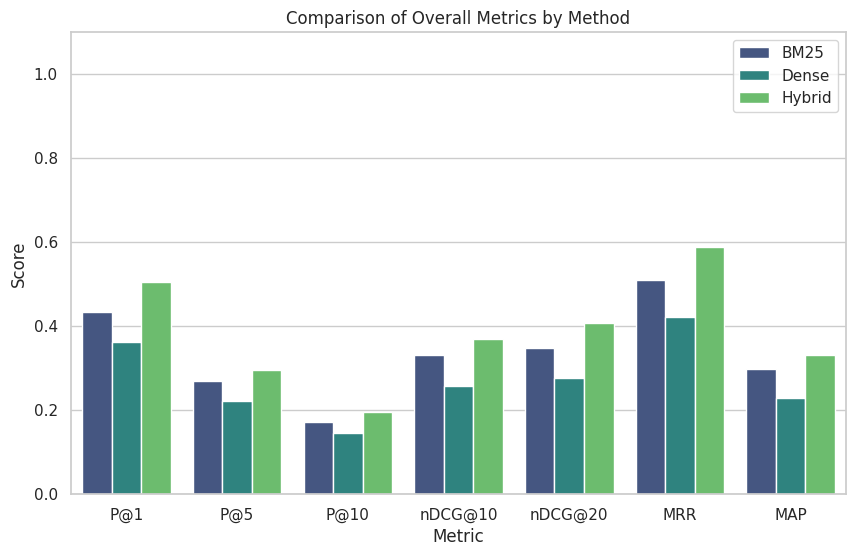

In [30]:
agg_data = []
method_names = ["BM25", "Dense", "Hybrid"]
method_results = [results_bm25, results_dense, results_hybrid]

for name, res in zip(method_names, method_results):
    agg_data.append({
        "Method": name,
        "P@1": res[ir_measures.P@1],
        "P@5": res[ir_measures.P@5],
        "P@10": res[ir_measures.P@10],
        "nDCG@10": res[ir_measures.nDCG@10],
        "nDCG@20": res[ir_measures.nDCG@20],
        "MRR": res[ir_measures.RR],
        "MAP": res[ir_measures.AP],
    })

df_agg = pd.DataFrame(agg_data)
print(df_agg)
df_agg.to_csv(os.path.join(output_dir, "aggregate_metrics.csv"), index=False)
print(f"Aggregate metrics saved to {os.path.join(output_dir, 'aggregate_metrics.csv')}")

df_melt = df_agg.melt(id_vars=["Method"], var_name="Metric", value_name="Score")

plt.figure(figsize=(10,6))
sns.barplot(data=df_melt, x="Metric", y="Score", hue="Method", palette="viridis")
plt.ylim(0, 1.1)
plt.title("Comparison of Overall Metrics by Method")
plt.legend(loc="best")
plt.savefig(os.path.join(output_dir, "overall_metrics_barplot.png"))
plt.show()

Per-query metrics saved to evaluation_results/per_query_metrics.csv


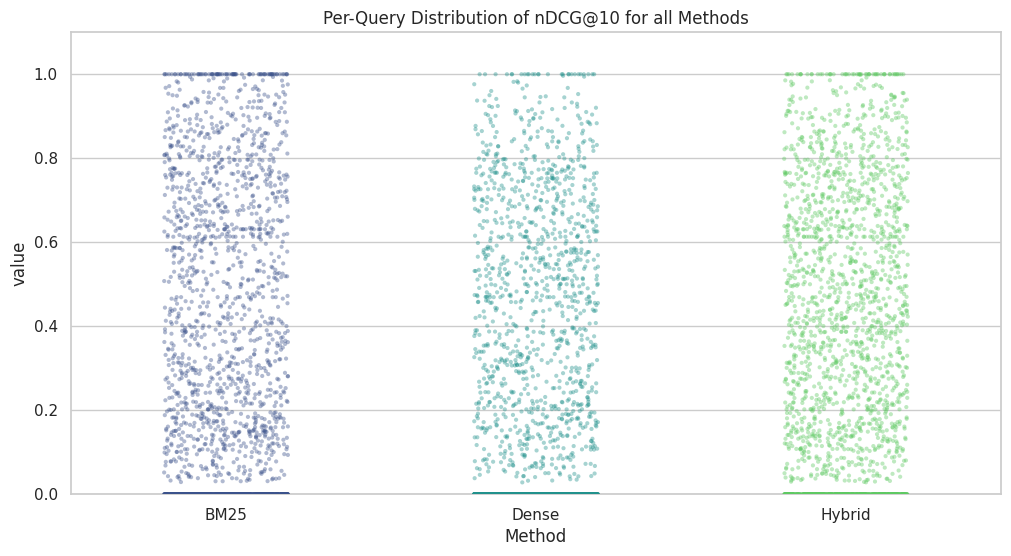

In [31]:
# 1) BM25
bm25_per_query = list(ir_measures.iter_calc(metrics, qrel_list, bm25_run_list))
df_bm25_per_query = []
for entry in bm25_per_query:
    df_bm25_per_query.append({
        "qid": entry.query_id,
        "metric": str(entry.measure),  
        "value": entry.value,
        "Method": "BM25"
    })
df_bm25_per_query = pd.DataFrame(df_bm25_per_query)

# 2) Dense
dense_per_query = list(ir_measures.iter_calc(metrics, qrel_list, dense_run_list))
df_dense_per_query = []
for entry in dense_per_query:
    df_dense_per_query.append({
        "qid": entry.query_id,
        "metric": str(entry.measure),
        "value": entry.value,
        "Method": "Dense"
    })
df_dense_per_query = pd.DataFrame(df_dense_per_query)

# 3) Hybrid
hybrid_per_query = list(ir_measures.iter_calc(metrics, qrel_list, hybrid_run_list))
df_hybrid_per_query = []
for entry in hybrid_per_query:
    df_hybrid_per_query.append({
        "qid": entry.query_id,
        "metric": str(entry.measure),
        "value": entry.value,
        "Method": "Hybrid"
    })
df_hybrid_per_query = pd.DataFrame(df_hybrid_per_query)
df_all_per_query = pd.concat([df_bm25_per_query, df_dense_per_query, df_hybrid_per_query], ignore_index=True)

df_all_per_query.to_csv(os.path.join(output_dir, "per_query_metrics.csv"), index=False)
print(f"Per-query metrics saved to {os.path.join(output_dir, 'per_query_metrics.csv')}")


df_ndcg10 = df_all_per_query[df_all_per_query["metric"] == "nDCG@10"] 
plt.figure(figsize=(12,6))

sns.stripplot(data=df_ndcg10, x="Method", y="value", hue="Method", legend=False, palette="viridis", 
               size=3, jitter=0.2, alpha=0.4)

plt.title("Per-Query Distribution of nDCG@10 for all Methods")
plt.ylim(0, 1.1)
plt.savefig(os.path.join(output_dir, "ndcg10_stripplot.png"))
plt.show()

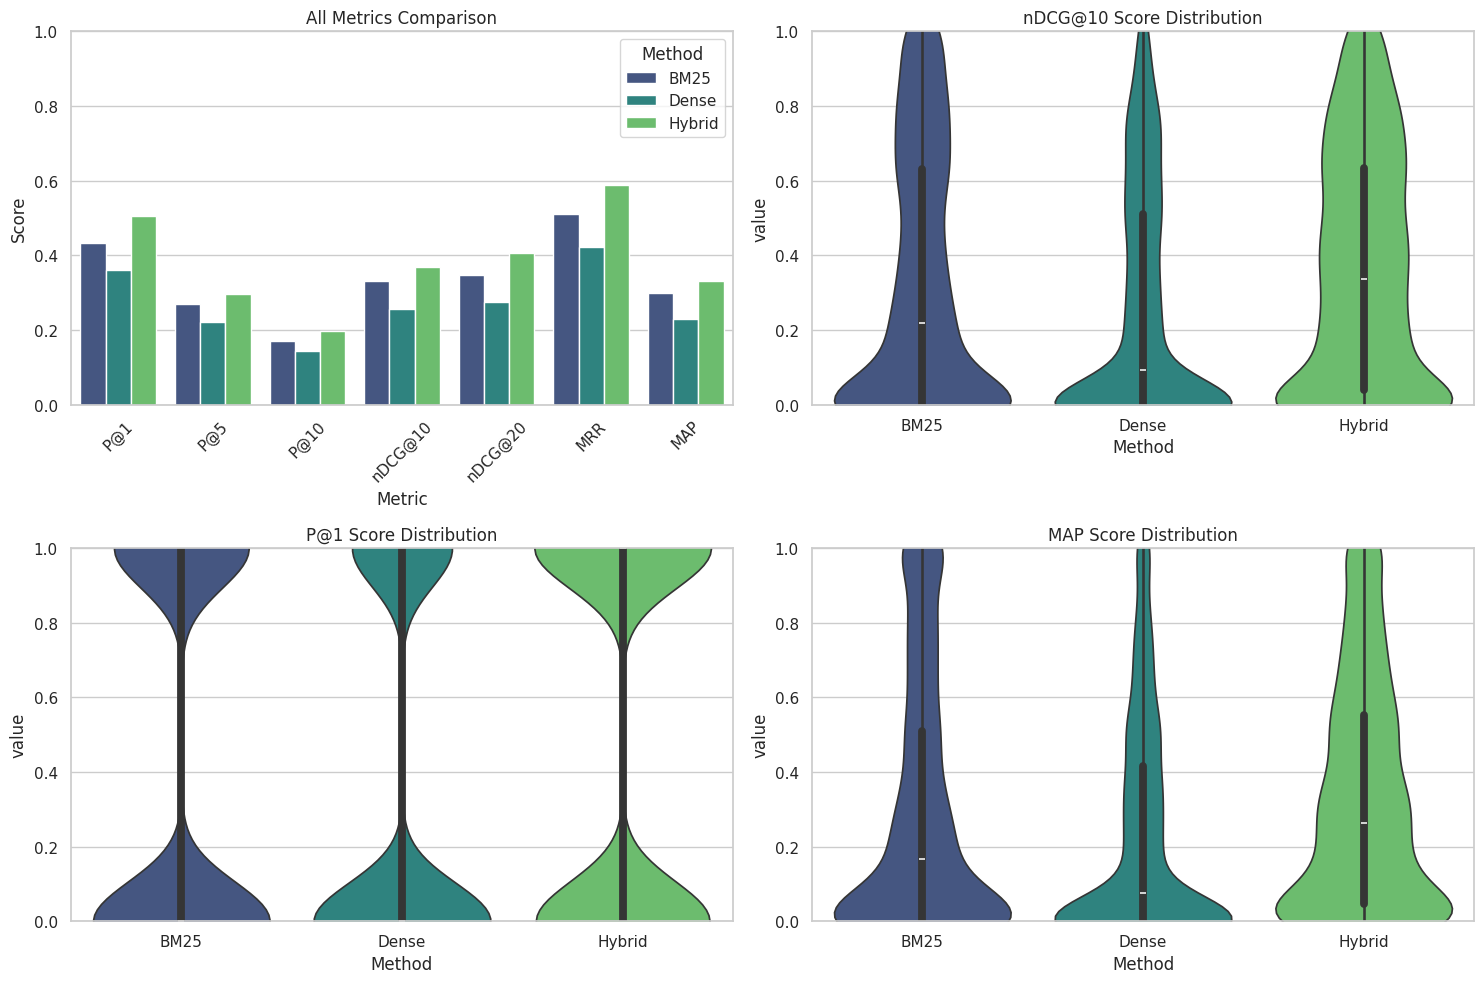


Metric: P@1
Average scores:
Method      P@1
  BM25 0.432666
 Dense 0.361237
Hybrid 0.504095

Improvement percentages:
Dense vs BM25: -16.51%
Hybrid vs BM25: 16.51%
Hybrid vs Dense: 39.55%

Metric: P@5
Average scores:
Method      P@5
  BM25 0.268244
 Dense 0.220837
Hybrid 0.295996

Improvement percentages:
Dense vs BM25: -17.67%
Hybrid vs BM25: 10.35%
Hybrid vs Dense: 34.03%

Metric: P@10
Average scores:
Method     P@10
  BM25 0.170701
 Dense 0.144449
Hybrid 0.195951

Improvement percentages:
Dense vs BM25: -15.38%
Hybrid vs BM25: 14.79%
Hybrid vs Dense: 35.65%

Metric: nDCG@10
Average scores:
Method  nDCG@10
  BM25 0.330222
 Dense 0.256583
Hybrid 0.369864

Improvement percentages:
Dense vs BM25: -22.30%
Hybrid vs BM25: 12.00%
Hybrid vs Dense: 44.15%

Metric: nDCG@20
Average scores:
Method  nDCG@20
  BM25 0.347616
 Dense 0.275896
Hybrid 0.406591

Improvement percentages:
Dense vs BM25: -20.63%
Hybrid vs BM25: 16.97%
Hybrid vs Dense: 47.37%

Metric: MRR
Average scores:
Method      MRR
 

/tmp/ipykernel_6952/2331780771.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_method_counts = metric_data.groupby('qid').apply(
/tmp/ipykernel_6952/2331780771.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_method_counts = metric_data.groupby('qid').apply(



P@1:
BM25      1644
Dense      371
Hybrid     183
Name: count, dtype: int64

P@5:
BM25      1293
Dense      570
Hybrid     335
Name: count, dtype: int64


/tmp/ipykernel_6952/2331780771.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_method_counts = metric_data.groupby('qid').apply(



P@10:
BM25      1231
Dense      585
Hybrid     382
Name: count, dtype: int64


/tmp/ipykernel_6952/2331780771.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_method_counts = metric_data.groupby('qid').apply(



nDCG@10:
BM25      965
Hybrid    663
Dense     570
Name: count, dtype: int64


/tmp/ipykernel_6952/2331780771.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_method_counts = metric_data.groupby('qid').apply(



nDCG@20:
BM25      891
Hybrid    735
Dense     572
Name: count, dtype: int64


/tmp/ipykernel_6952/2331780771.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_method_counts = metric_data.groupby('qid').apply(
/tmp/ipykernel_6952/2331780771.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_method_counts = metric_data.groupby('qid').apply(



RR:
BM25      1306
Dense      520
Hybrid     372
Name: count, dtype: int64

AP:
BM25      915
Hybrid    707
Dense     576
Name: count, dtype: int64
Statistical analysis saved to evaluation_results/statistical_analysis.txt


In [34]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.barplot(data=df_melt, x="Metric", y="Score", hue="Method", palette="viridis")
plt.xticks(rotation=45)
plt.title("All Metrics Comparison")
plt.ylim(0, 1)

plt.subplot(2, 2, 2)
sns.violinplot(data=df_ndcg10, x="Method", y="value", hue="Method", legend=False, palette="viridis")
plt.title("nDCG@10 Score Distribution")
plt.ylim(0, 1)

df_p1 = df_all_per_query[df_all_per_query["metric"] == "P@1"]
plt.subplot(2, 2, 3)
sns.violinplot(data=df_p1, x="Method", y="value", hue="Method", legend=False, palette="viridis")
plt.title("P@1 Score Distribution")
plt.ylim(0, 1)

df_map = df_all_per_query[df_all_per_query["metric"] == "AP"]
plt.subplot(2, 2, 4)
sns.violinplot(data=df_map, x="Method", y="value", hue="Method", legend=False, palette="viridis")
plt.title("MAP Score Distribution")
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "multiple_metric_distributions.png"))
plt.show()

statistical_results = {}
for metric in ['P@1', 'P@5', 'P@10', 'nDCG@10', 'nDCG@20', 'MRR', 'MAP']:
    print(f"\nMetric: {metric}")
    statistical_results[metric] = {}
    print("Average scores:")
    print(df_agg[['Method', metric]].to_string(index=False))
    statistical_results[metric]['average_scores'] = df_agg[['Method', metric]].to_string(index=False)
    print("\nImprovement percentages:")
    bm25_score = df_agg[df_agg['Method'] == 'BM25'][metric].values[0]
    dense_score = df_agg[df_agg['Method'] == 'Dense'][metric].values[0]
    hybrid_score = df_agg[df_agg['Method'] == 'Hybrid'][metric].values[0]

    improvement_dense_vs_bm25 = ((dense_score - bm25_score) / bm25_score * 100)
    improvement_hybrid_vs_bm25 = ((hybrid_score - bm25_score) / bm25_score * 100)
    improvement_hybrid_vs_dense = ((hybrid_score - dense_score) / dense_score * 100)

    print(f"Dense vs BM25: {improvement_dense_vs_bm25:.2f}%")
    print(f"Hybrid vs BM25: {improvement_hybrid_vs_bm25:.2f}%")
    print(f"Hybrid vs Dense: {improvement_hybrid_vs_dense:.2f}%")

    statistical_results[metric]['improvement_percentages'] = {
        "Dense vs BM25": f"{improvement_dense_vs_bm25:.2f}%",
        "Hybrid vs BM25": f"{improvement_hybrid_vs_bm25:.2f}%",
        "Hybrid vs Dense": f"{improvement_hybrid_vs_dense:.2f}%"
    }

print("\nQuery-level Analysis:")
print("\nNumber of queries where each method performs best:")
query_level_analysis_results = {}
for metric in ['P@1', 'P@5', 'P@10', 'nDCG@10', 'nDCG@20', 'RR', 'AP']:
    metric_data = df_all_per_query[df_all_per_query['metric'] == metric]
    best_method_counts = metric_data.groupby('qid').apply(
        lambda x: x.loc[x['value'].idxmax(), 'Method']
    ).value_counts()

    print(f"\n{metric}:")
    print(best_method_counts)
    query_level_analysis_results[metric] = best_method_counts.to_dict()

# def perform_statistical_tests(data, metric_name):
#     bm25_data = data[data['Method'] == 'BM25']['value']
#     dense_data = data[data['Method'] == 'Dense']['value']
#     hybrid_data = data[data['Method'] == 'Hybrid']['value']

#     bm25_vs_dense = stats.wilcoxon(bm25_data, dense_data)
#     bm25_vs_hybrid = stats.wilcoxon(bm25_data, hybrid_data)
#     dense_vs_hybrid = stats.wilcoxon(dense_data, hybrid_data)

#     print(f"\nStatistical Tests for {metric_name}")
#     print(f"BM25 vs Dense: p-value = {bm25_vs_dense.pvalue:.6f}")
#     print(f"BM25 vs Hybrid: p-value = {bm25_vs_hybrid.pvalue:.6f}")
#     print(f"Dense vs Hybrid: p-value = {dense_vs_hybrid.pvalue:.6f}")

#     return {
#         "BM25 vs Dense": f"p-value = {bm25_vs_dense.pvalue:.6f}",
#         "BM25 vs Hybrid": f"p-value = {bm25_vs_hybrid.pvalue:.6f}",
#         "Dense vs Hybrid": f"p-value = {dense_vs_hybrid.pvalue:.6f}"
#     }

# statistical_tests_results = {}
# for metric in ['nDCG@10', 'P@1', 'AP']:
#     metric_data = df_all_per_query[df_all_per_query['metric'] == metric]
#     test_results = perform_statistical_tests(metric_data, metric)
#     statistical_tests_results[metric] = test_results

with open(os.path.join(output_dir, "statistical_analysis.txt"), "w") as f:
    f.write("Statistical Analysis\n\n")
    for metric, results in statistical_results.items():
        f.write(f"Metric: {metric}\n")
        f.write("Average scores:\n")
        f.write(results.get('average_scores', ''))
        f.write("\nImprovement percentages:\n")
        for k, v in results.get('improvement_percentages', {}).items():
            f.write(f"{k}: {v}\n")
        f.write("\n")

    f.write("\nQuery-level Analysis:\n")
    f.write("Number of queries where each method performs best:\n")
    for metric, counts in query_level_analysis_results.items():
        f.write(f"\n{metric}:\n")
        for method, count in counts.items():
            f.write(f"{method}: {count}\n")

print(f"Statistical analysis saved to {os.path.join(output_dir, 'statistical_analysis.txt')}")